# SysArmy - Análisis de encuesta 2020.02 - COVID

## 1. Carga y sanitización de datos

###  1.1. Definimos los metadatos asociados al dataset que vamos a analizar

In [1]:
csv_url = "https://raw.githubusercontent.com/openqube/openqube-sueldos/master/data/csv/argentina/2020.02.csv"

dataset_metadata = {"year": 2020,
                    "part": 2,
                    "skiprows": 0,
                    "publish_date": "2020-08-15",
                    "minimum_salary": 16875} # https://es.wikipedia.org/wiki/Anexo:Salario_m%C3%ADnimo_en_Argentina

### 1.2. En base a los metadatos, cargamos el CSV, limpiamos columnas y las transformamos

In [2]:
import pandas as pd
import io
import requests
from time import sleep
import matplotlib.pyplot as plt

raw_dataframe = None
source = requests.get(csv_url).content
raw_dataframe = pd.read_csv(io.StringIO(source.decode("utf-8")),
                            skiprows=dataset_metadata["skiprows"],
                            thousands=".",
                            decimal=",")

import re

regex_white_chars = re.compile(r"\s+")
regex_non_alphanum = re.compile(r"\W+_?", re.I)

raw_dataframe.columns = (raw_dataframe.columns.str.strip()
                         .str.lower()
                         .str.replace(regex_white_chars, "_")
                         .str.replace(regex_non_alphanum, "")
                         .str.translate("ñáéíóú".maketrans({"ñ": "n", "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"})))

# Eliminamos los datos que no pertenezcan a Argentina
raw_dataframe = raw_dataframe[raw_dataframe["estoy_trabajando_en"] == "Argentina"]

# Conservamos únicamente las columnas relacionadas con COVID-19
columns_to_keep = ["timestamp",
                   "me_identifico",
                   "donde_estas_trabajando",
                   "trabajo_de",
                   "tipo_de_contrato",
                   "salario_mensual_bruto_en_tu_moneda_local",
                   "como_venis_llevando_la_cuarentena",
                   "tenes_hijosas_menores_de_edad",
                   "con_cuantas_personas_estas_conviviendo",
                   "con_quienes_convivis",
                   "tenes_un_espacio_dedicado_para_el_trabajo",
                   "tenes_que_compartir_tu_equipo_de_trabajo_con_alguien",
                   "que_tipo_de_cuarentena_estas_haciendo",
                   "cambio_tu_situacion_laboral_a_raiz_de_la_pandemia",
                   "que_tanto_sentis_que_te_esta_apoyando_tu_empresa_en_esta_situacion",
                   "como_se_vio_afectada_tu_empresa",
                   "instauraron_algun_beneficio_nuevo",
                   "actividad_principal",
                   "cantidad_de_empleados",
                   "anos_de_experiencia"]

raw_dataframe = raw_dataframe[columns_to_keep]


df = raw_dataframe.copy()
df.head()

,timestamp,me_identifico,donde_estas_trabajando,trabajo_de,tipo_de_contrato,salario_mensual_bruto_en_tu_moneda_local,como_venis_llevando_la_cuarentena,tenes_hijosas_menores_de_edad,con_cuantas_personas_estas_conviviendo,con_quienes_convivis,tenes_un_espacio_dedicado_para_el_trabajo,tenes_que_compartir_tu_equipo_de_trabajo_con_alguien,que_tipo_de_cuarentena_estas_haciendo,cambio_tu_situacion_laboral_a_raiz_de_la_pandemia,que_tanto_sentis_que_te_esta_apoyando_tu_empresa_en_esta_situacion,como_se_vio_afectada_tu_empresa,instauraron_algun_beneficio_nuevo,actividad_principal,cantidad_de_empleados,anos_de_experiencia
0,7/6/2020 9:56:02,Mujer,Ciudad Autónoma de Buenos Aires,Consultant,Full-Time,53000,3,0,0,Vivo solo/a,No,No,4,Decidí buscar otro trabajo,7,No la afectó,No,Servicios / Consultoría de Software / Digital,501-1000,3
1,7/6/2020 9:57:09,Hombre,Corrientes,Developer,Full-Time,79000,2,0,1,-,No,No,3,"Cambié de trabajo, pero no por la pandemia",8,No la afectó,No,Otras industrias,201-500,5
2,7/6/2020 9:58:09,Mujer,Ciudad Autónoma de Buenos Aires,Infosec,Full-Time,160000,3,0,1,Pareja,No,No,4,"Cambié de trabajo, pero no por la pandemia",8,Se vio beneficiada,"Clases de gimnasia, Clases de meditación, Clas...",Otras industrias,2001-5000,2
3,7/6/2020 9:59:52,Hombre,Corrientes,SysAdmin / DevOps / SRE,Full-Time,130000,2,0,1,Pareja,Sí,No,4,No,4,"Cerró oficinas, Bajaron los sueldos o pagan pa...",No,Otras industrias,501-1000,15
4,7/6/2020 10:01:27,Hombre,Ciudad Autónoma de Buenos Aires,Developer,Full-Time,140000,2,1,2,"Pareja, Hijos/as (tiempo completo)",Sí,No,3,No,6,Nos obligaron a tomarnos vacaciones,No,Servicios / Consultoría de Software / Digital,11-50,9


### 1.3. Sanitizamos/normalizamos datos que encontramos mal formados o repetidos

In [3]:
import re

# Given a Dataframe (df), a column name that identifies the column to sanitize,
# applies an in-place replacement for each pair regex-value in the map

def normalize_dataframe_column(df_in, column_name, regex_assign_map):
    df_out = df_in.copy()
    for regex, value in regex_assign_map.items():
        compiled_regex = re.compile(regex, re.I)
        mask = df_in[column_name].str.strip().str.match(compiled_regex, na=False)
        df_out.loc[mask, column_name] = value
    # debug
    #     total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    #     display("reduced in {:02f}".format((total - final) / total))
    return df_out


def normalize_dataframe_column_replace(df_in, column_name, regex_replace_map):
    df_out = df_in.copy()
    for regex, pattern in regex_replace_map.items():
        compiled_regex = re.compile(regex, re.I)
        df_out[column_name] = (df_out[column_name].str.strip().str.replace(compiled_regex, pattern))
    # debug
    #     total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    #     display("reduced in {:02f}".format((total - final) / total))
    return df_out

#### 1.3.1. Regiones

In [4]:
df = normalize_dataframe_column(df, "donde_estas_trabajando", {"(GBA|Provincia de Buenos Aires)": "Buenos Aires"})

#### 1.3.2. Roles

In [5]:
df = normalize_dataframe_column_replace(df, "trabajo_de", 
                                        {"Project Manager.*": "Project Manager",
                                         "Director, Product Manager, Project Manager": "Manager / Director",
                                         "Technical Leader.*": "Technical Leader",
                                         "Team Leader.*": "Technical Leader",
                                         "Full ?Stack Developer": "Developer",
                                         "Seguridad Inform[aá]tica": "Infosec",
                                         "(profesor|instructor|educador|docente|capacitador.*)": "Docente",
                                         "^(Soporte T[ée]cnico|Technical support|Support)": "Technical Support",
                                         "Software Engineer": "Developer",
                                         "(Analista )?programador": "Developer",
                                         "Analista Funcional": "Functional Analyst",
                                         "Technical Functional Analyst": "Functional Analyst",
                                         "administrativo": "Administrativo",
                                         "^cto.*": "CTO",
                                         "Asistant": "Assistant",
                                         "helpdesk": "HelpDesk",
                                         "(Analista de seguridad|Security.*)": "Infosec",
                                         "BI Leader": "BI Analyst / Data Analyst"})

df_roles = df["trabajo_de"].value_counts(sort=True)
df_roles.head(10)

Developer                         2411
SysAdmin / DevOps / SRE            689
Technical Leader                   400
QA / Tester                        254
Manager / Director                 231
HelpDesk                           198
Project Manager                    193
Architect                          175
Data Scientist / Data Engineer     140
Consultant                         139
Name: trabajo_de, dtype: int64

#### 1.3.3. Experiencia

In [6]:
df["seniority"] = pd.cut(df["anos_de_experiencia"].values, [0, 2, 5, 50], 
                         labels=["Junior", "Semi-Senior", "Senior"])

### 1.4. Eliminamos outliers

In [7]:
def remove_outlier(df_in, col_name, iqr_factor=1.5):
#   IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
#   accept a dataframe, remove outliers, return cleaned data in a new dataframe
#   see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
        
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    
    df_inliers = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    df_outliers = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    
    return df_inliers, df_outliers

In [8]:
df_inliers, df_outliers = remove_outlier(df, "salario_mensual_bruto_en_tu_moneda_local", 3.5)

# inliers percent over total
display(len(df_inliers) / len(df))

0.9652173913043478

In [9]:
minimum_salary = dataset_metadata["minimum_salary"]

df_outliers_lower_limit = df_inliers.query("salario_mensual_bruto_en_tu_moneda_local < @minimum_salary/2.0")
df_inliers_lower_limit = df_inliers.query("salario_mensual_bruto_en_tu_moneda_local >= @minimum_salary/2.0")
df = df_inliers_lower_limit

## 2. Análisis de resultados

#### Los resultados del análisis exploratorio se exportan en un JSON denominado 'charts'

In [10]:
charts = {
    "total_surveyed": len(raw_dataframe),
    "total_analyzed_surveyed": len(df),
}

def to_rechart(df, max=0):
  # if max is set, groups the exceeded rows into 'Otros' column, summing values
    if max != 0:
        # df = df.sort_values(by, ascending=False)
        others = df[max:].sum()
        df = df[:max]
        df.loc["Otros"] = others
    return {
        "data": [
            {"name": str(name), **(data if isinstance(data, dict) else {"value": data})}
            for name, data in df.T.to_dict().items()
        ],
    }

### 2.1. Situación habitacional - Grupo familiar

#### 2.1.1. ¿Con cuántas personas convivís?

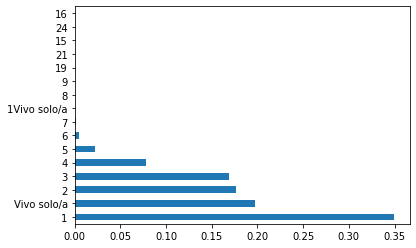

In [11]:
aux = df.copy()
aux["con_cuantas_personas_estas_conviviendo"] = aux["con_cuantas_personas_estas_conviviendo"].apply(str)

aux = normalize_dataframe_column_replace(aux, "con_cuantas_personas_estas_conviviendo", {"0": "Vivo solo/a"})
gph = aux["con_cuantas_personas_estas_conviviendo"].value_counts(normalize=True, sort=True)
gph.plot.barh();

charts["convivencia_cuanti"] = to_rechart(gph, 6)

#### 2.1.2. ¿Con quiénes estás conviviendo?

In [12]:
df["con_quienes_convivis"].value_counts().head(25)

Pareja                                                                                    1800
Familia de origen (madre/padre/hermanos/as)                                               1177
Vivo solo/a                                                                               1049
Pareja, Hijos/as (tiempo completo)                                                         927
Hijos/as (tiempo completo)                                                                 115
Amigos/as / Roomates                                                                        90
Familia de origen (madre/padre/hermanos/as), Pareja                                         88
Pareja, Hijos/as mayores de 18                                                              71
Pareja, Hijos/as (tiempo dividido)                                                          52
Pareja, Hijos/as mayores de 18, Hijos/as (tiempo completo)                                  50
Hijos/as (tiempo dividido)                        

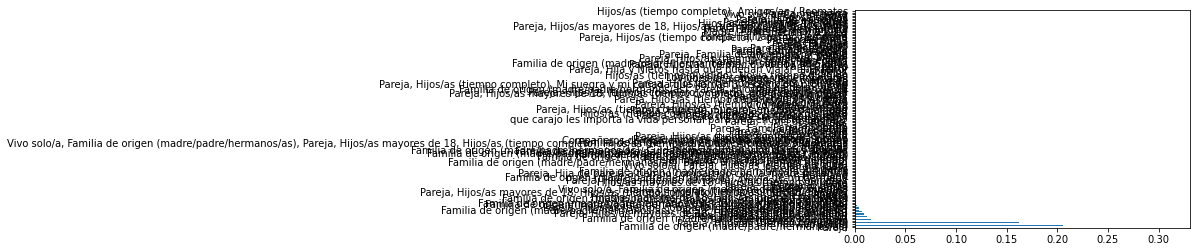

In [13]:
aux = df.copy()

gph = aux["con_quienes_convivis"].value_counts(normalize=True, sort=True)
gph.plot.barh();

charts["convivencia_cuali"] = to_rechart(gph, 6)

In [14]:
charts["convivencia_cuali"]

{'data': [{'name': 'Pareja', 'value': 0.31496062992125984},
  {'name': 'Familia de origen (madre/padre/hermanos/as)',
   'value': 0.20594925634295713},
  {'name': 'Vivo solo/a', 'value': 0.18355205599300087},
  {'name': 'Pareja, Hijos/as (tiempo completo)', 'value': 0.16220472440944883},
  {'name': 'Hijos/as (tiempo completo)', 'value': 0.020122484689413824},
  {'name': 'Amigos/as / Roomates', 'value': 0.015748031496062992},
  {'name': 'Otros', 'value': 0.09746281714785651}]}

#### 2.1.3. ¿Tenés hijos/as menores de edad?

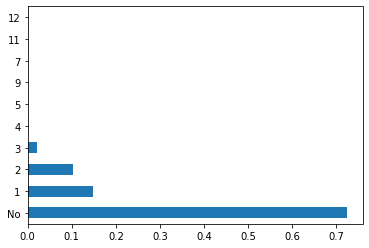

In [15]:
aux = df.copy()
aux["tenes_hijosas_menores_de_edad"] = aux["tenes_hijosas_menores_de_edad"].apply(str)

aux = normalize_dataframe_column_replace(aux, "tenes_hijosas_menores_de_edad", {"0": "No"})
gph = aux["tenes_hijosas_menores_de_edad"].value_counts(normalize=True)
gph.plot.barh();

charts["tenes_hijoas"] = to_rechart(gph, 4)

### 2.2. Situación personal


#### 2.2.1. ¿Cómo venís llevando la cuarentena?

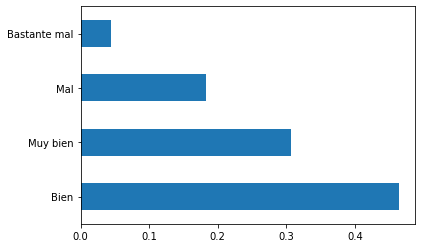

In [16]:
labels = {"1":"Bastante mal", "2":"Mal", "3":"Bien", "4":"Muy bien"}

aux = df.copy()
aux["como_venis_llevando_la_cuarentena"] = aux["como_venis_llevando_la_cuarentena"].apply(str)

aux = normalize_dataframe_column_replace(aux, "como_venis_llevando_la_cuarentena", labels)
gph = aux["como_venis_llevando_la_cuarentena"].value_counts(normalize=True)
gph.plot.barh();

charts["como_venis_llevando"] = to_rechart(gph)

#### 2.2.2. Quienes están pasándola "Mal" o "Bastante mal", ¿con quién/es conviven?


In [17]:
fgroup = ["Pareja", "Familia de origen (madre/padre/hermanos/as)", "Vivo solo/a", "Pareja, Hijos/as (tiempo completo)",
       "Hijos/as (tiempo completo)", "Amigos/as / Roomates"]

aux = df.copy()
conv = aux['pasandola_bien'] = aux['como_venis_llevando_la_cuarentena'].isin([3, 4])
conv = aux.groupby(["pasandola_bien", "con_quienes_convivis"])["con_quienes_convivis"].count().unstack("pasandola_bien").fillna(0).sort_values(by=1, ascending=False)

conv = conv.query("con_quienes_convivis in @fgroup")
conv.div(conv.sum(axis=1), axis=0)

pasandola_bien,False,True
con_quienes_convivis,,
Pareja,0.190556,0.809444
Familia de origen (madre/padre/hermanos/as),0.249788,0.750212
Vivo solo/a,0.269781,0.730219
"Pareja, Hijos/as (tiempo completo)",0.238403,0.761597
Hijos/as (tiempo completo),0.226087,0.773913
Amigos/as / Roomates,0.177778,0.822222


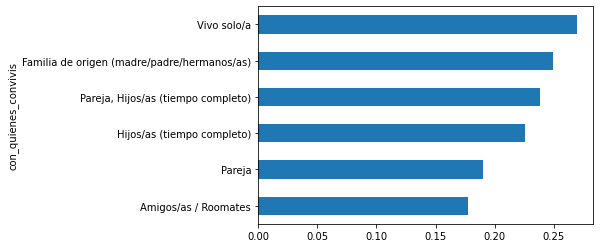

In [18]:
conv_pm = conv.div(conv.sum(axis=1), axis=0).loc[:, 0].sort_values()
conv_pm.plot(kind="barh", ax=plt.gca());
charts["convivencia_pasandola_mal"] = to_rechart(conv_pm)

#### 2.2.3. ¿Qué tipo de cuarentena estás haciendo?

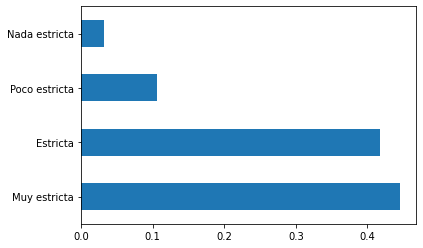

In [19]:
labels = {"1":"Nada estricta", "2":"Poco estricta", "3":"Estricta", "4":"Muy estricta"}

aux = df.copy()
aux["que_tipo_de_cuarentena_estas_haciendo"] = aux["que_tipo_de_cuarentena_estas_haciendo"].apply(str)

aux = normalize_dataframe_column_replace(aux, "que_tipo_de_cuarentena_estas_haciendo", labels)
gph = aux["que_tipo_de_cuarentena_estas_haciendo"].value_counts(normalize=True)
gph.plot.barh();

charts["tipo_de_cuarentena"] = to_rechart(gph)

### 2.3. Espacio de trabajo

#### 2.3.1. ¿Tenés un espacio dedicado para el trabajo?

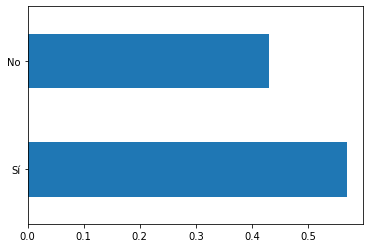

In [20]:
aux = df.copy()

gph = aux["tenes_un_espacio_dedicado_para_el_trabajo"].value_counts(normalize=True, sort=True)
gph.plot.barh();

charts["espacio_trabajo"] = to_rechart(gph)

#### 2.3.2. ¿Tenés que compartir tu equipo de trabajo con alguien?

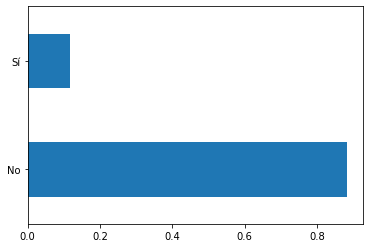

In [21]:
aux = df.copy()

gph = aux["tenes_que_compartir_tu_equipo_de_trabajo_con_alguien"].value_counts(normalize=True, sort=True)
gph.plot.barh();

charts["espacio_trabajo_compartido"] = to_rechart(gph)

#### 2.3.3. Cómo se lleva la cuarentena según espacio de trabajo

#### ¿Influye el hecho de tener un espacio dedicado al trabajo a cómo se lleva la cuarentena?

Como observamos en 2.2.1, el porcentaje de gente que la está pasando peor (Mal y Bastante Mal) es aproximadamente un 22%. Analizaremos cómo afecta a este hecho el tener un espacio de trabajo específico:

como_venis_llevando_la_cuarentena
1    0.044269
2    0.183377
3    0.464917
4    0.307437
dtype: float64

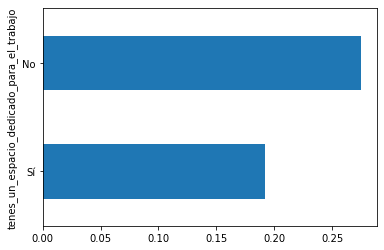

In [22]:
aux = df.copy()
wp = aux.groupby(["como_venis_llevando_la_cuarentena", "tenes_un_espacio_dedicado_para_el_trabajo"])["tenes_un_espacio_dedicado_para_el_trabajo"].count().unstack("como_venis_llevando_la_cuarentena").fillna(0).sort_values(by=1, ascending=False)
wp_rel = wp.div(wp.sum(axis=1), axis=0)
display(wp.sum(axis=0) / (253 + 1048 + 2657 + 1757))
wpp = wp_rel[[1, 2]].sum(axis=1)
wpp.plot(kind='barh');
charts["espacio_trabajo_llevando_cuarentena"] = to_rechart(wpp)

Podemos ver que dentro de la gente sin un espacio dedicado al trabajo hay un mayor porcentaje que se encuentra pasándola "mal" o "bastante mal" (27%), mientras que entre quienes si tienen un espacio laboral dedicado este número es del 18%. 

### 2.4. Situación laboral

#### 2.4.1. ¿Cambió tu situación laboral a raíz de la pandemia?

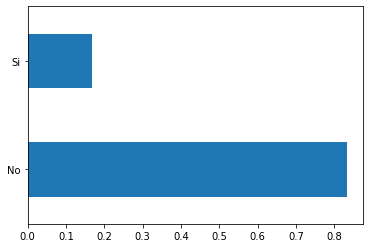

In [23]:
aux = df.copy()
aux["cambio_situacion"] = (aux.cambio_tu_situacion_laboral_a_raiz_de_la_pandemia != "No").apply(str)
labels = {"False": "No", "True": "Si"}
aux = normalize_dataframe_column_replace(aux, "cambio_situacion", labels)

csl = aux["cambio_situacion"].value_counts(normalize=True)
csl.plot.barh();
charts["cambio_situacion"] = to_rechart(csl)

#### 2.4.1.1. Cambio de situación laboral por género

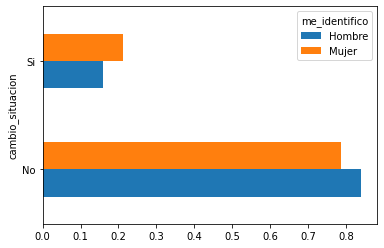

In [24]:
# 'Otros' con datos insuficientes
gs = aux.groupby(['me_identifico', 'cambio_situacion'])['cambio_situacion'].count().unstack()
gs = gs.div(gs.sum(axis=1), axis=0)
gs.loc[['Hombre', 'Mujer']].T.plot.barh();
charts["cambio_situacion_genero"] = to_rechart(gs["Si"])

#### 2.4.1.2. Cambio de situación laboral por experiencia 

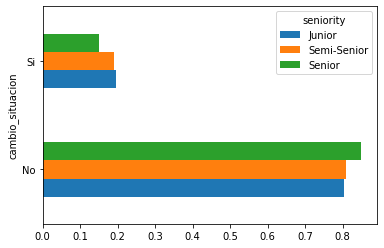

In [25]:
sen = aux.groupby(['seniority', 'cambio_situacion'])['cambio_situacion'].count().unstack()
sen = sen.div(sen.sum(axis=1), axis=0)
sen.loc[['Junior', 'Semi-Senior', 'Senior']].T.plot.barh();
charts["cambio_situacion_seniority"] = to_rechart(sen["Si"])

#### 2.4.2. Si cambió, ¿cómo?

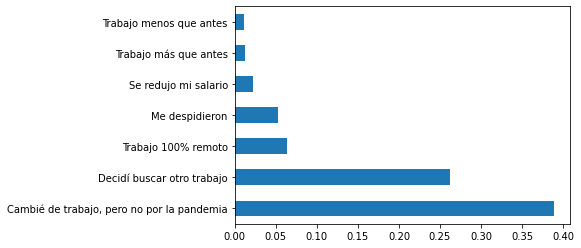

In [26]:
reduction = r"(reducci[óo]n|redujeron|reducir|reducieron|recortaron|bajaron|reduje|menos|paralizar[on]|sin aumento|eliminaron)"
hours = r"(horas?|horario|hs)"
less_hours = rf".*{reduction}.*{hours}.*"
money = "(sueldo|aumento[s]|salario|ajustes|salarial)"
less_salary = rf".*{reduction}.*{money}.*"
more_hours = rf".*(m[aá]s|increment[oó]|aument[ée]).*{hours}|(trabajo).*"
homeoffice = r".*(remoto|teletrabajo|home ?office|ho[nm]eworking|trabajo desde casa|wfh|remote-first|trabajar de forma remota|home office).*"

cambio_norm = normalize_dataframe_column(
    aux[aux.cambio_situacion == "Si"],
    "cambio_tu_situacion_laboral_a_raiz_de_la_pandemia",
    {
        less_salary: "Se redujo mi salario",
        less_hours: "Trabajo menos que antes",
        more_hours: "Trabajo más que antes",
        homeoffice: "Trabajo 100% remoto",
    },
)

csl_c = cambio_norm.cambio_tu_situacion_laboral_a_raiz_de_la_pandemia.value_counts(normalize=True)
csl_c[:7].plot.barh()
charts["como_cambio_norm"] = to_rechart(csl_c[:7])

#### 2.4.3. ¿Qué tanto sentís que te está apoyando tu empresa en esta situación?

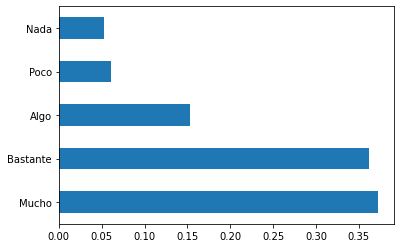

In [27]:
aux = df.copy()

labels = ["Nada", "Poco", "Algo", "Bastante", "Mucho"]
support = pd.cut(aux["que_tanto_sentis_que_te_esta_apoyando_tu_empresa_en_esta_situacion"], range(0, 11, 2), include_lowest=True, labels=labels).value_counts(normalize=True)
support.plot.barh();
charts["apoyando_empresa"]= to_rechart(support)

#### 2.4.4. ¿Se vio afectada tu empresa?

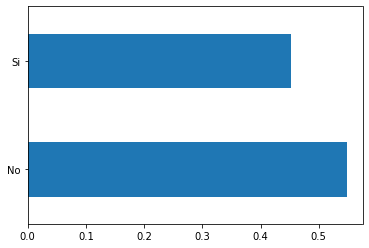

In [28]:
aux = df.copy()
aux["afecto_empresa"] = aux.como_se_vio_afectada_tu_empresa.str.contains("No la afectó").dropna()
aux["afecto_empresa"] = ~aux["afecto_empresa"].astype(bool)
aux["afecto_empresa"] = aux["afecto_empresa"].apply(str)
labels = {"False": "No", "True": "Si"}
aux = normalize_dataframe_column_replace(aux, "afecto_empresa", labels)

ae = aux["afecto_empresa"].value_counts(normalize=True)
ae.plot.barh();
charts["afecto_empresa"] = to_rechart(ae)

#### 2.4.5. Empresas afectadas, por tipo de empresa

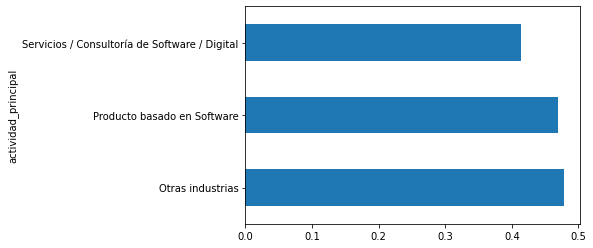

In [29]:
ap = aux.groupby(['actividad_principal', 'afecto_empresa'])['afecto_empresa'].count().unstack('afecto_empresa')
ap = ap.div(ap.sum(axis=1), axis=0)['Si']
ap.plot.barh();
charts["afecto_empresa_por_tipo"] = to_rechart(ap)

#### 2.4.6. Empresas afectadas, por tamaño de empresa

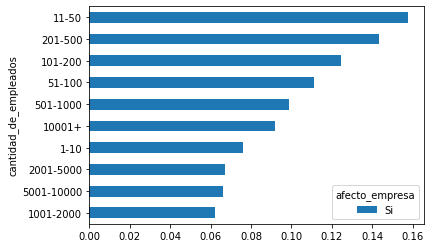

In [30]:
aux = aux[aux["afecto_empresa"] == "Si"]
aff = aux.groupby(["afecto_empresa", "cantidad_de_empleados"])["afecto_empresa"].count().unstack("cantidad_de_empleados")
aff = aff.div(aff.sum(axis=1), axis=0)

aff_s = aff.T.sort_values(by='Si')
aff_s.plot.barh();
charts["afecto_empresa_por_tamaño"] = to_rechart(aff_s)

#### 2.4.7. ¿Cómo se vio afectada tu empresa?

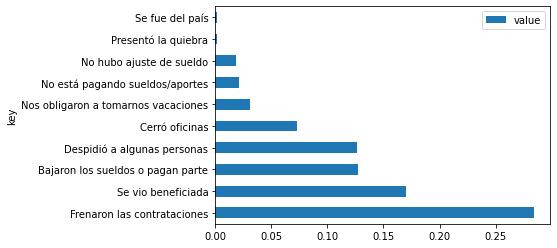

In [31]:
afecto_empresa = (
    aux[aux["afecto_empresa"] == "Si"].como_se_vio_afectada_tu_empresa
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
afecto_empresa.reset_index(level=0, inplace=True)

afecto_empresa = normalize_dataframe_column(
    afecto_empresa,
    "key",
    {
        ".*(no|frenar).*(aumentos?|ajustes?).*$": "No hubo ajuste de sueldo",
        "^(No se|a|pero existen|-|Cambie de trabajo)$": "DELETEME",
    },
)
afecto_empresa_total = afecto_empresa.query("key != 'DELETEME'").groupby("key").sum()["value"].sum()
afecto_empresa_f = (afecto_empresa.query("key != 'DELETEME'").groupby("key").sum()["value"].sort_values(ascending=False).to_frame()  / afecto_empresa_total)

afecto_empresa_f[:10].plot.barh()
charts["afecto_empresa_como"] = to_rechart(afecto_empresa_f[:10])

#### 2.4.8. ¿Instauraron algún beneficio nuevo?

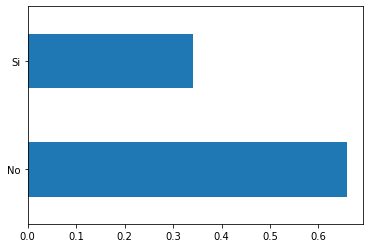

In [32]:
aux = df.copy()
aux["beneficio_nuevo"] = (aux.instauraron_algun_beneficio_nuevo != "No").apply(str)
labels = {"False": "No", "True": "Si"}
aux = normalize_dataframe_column_replace(aux, "beneficio_nuevo", labels)
bn = aux["beneficio_nuevo"].value_counts(normalize=True)
bn.plot.barh();
charts["beneficio_nuevo"] = to_rechart(bn)

#### 2.4.9. ¿Cuál?

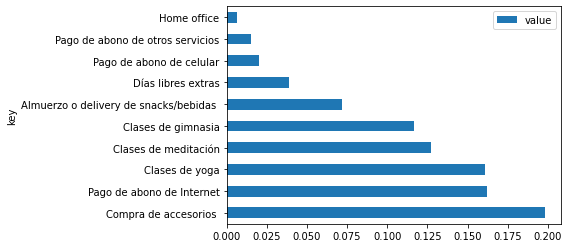

In [33]:
# remove commas from values since they're used to separate different values later
no_commas = aux[aux["beneficio_nuevo"] == "Si"].instauraron_algun_beneficio_nuevo
no_commas = no_commas.str.replace("\(.*\)", "")

beneficios = (
    no_commas
    .str.extractall(r"(?P<value>[^,]+),? ?")["value"]
    .value_counts(normalize=False, sort=True)
    .to_frame()
    .rename_axis("key")
)
beneficios.reset_index(level=0, inplace=True)
beneficios = normalize_dataframe_column(
    beneficios,
    "key",
    {
        "(home ?office|teletrabajo?|trabajo remoto)": "Home office",
        "^(No|etc)$": "DELETEME",
    },
)
beneficios_tot = beneficios.query("key != 'DELETEME'").groupby("key").sum()["value"].sum()
beneficios_f = beneficios.query("key != 'DELETEME'").groupby("key").sum()["value"].sort_values(ascending=False).to_frame() / beneficios_tot
beneficios_f[:10].plot.barh();
charts["beneficios_extra"] = to_rechart(beneficios_f[:10])

In [34]:
import json

# formateamos valores flotantes para ahorrar caracteres (#macritips)
display(
    json.dumps(
        json.loads(
            json.dumps(charts, allow_nan=False),
            parse_float=lambda x: round(float(x), 5),
        )
    )
)

'{"total_surveyed": 6095, "total_analyzed_surveyed": 5715, "convivencia_cuanti": {"data": [{"name": "1", "value": 0.34891}, {"name": "Vivo solo/a", "value": 0.19703}, {"name": "2", "value": 0.17603}, {"name": "3", "value": 0.16938}, {"name": "4", "value": 0.07769}, {"name": "5", "value": 0.02257}, {"name": "Otros", "value": 0.0084}]}, "convivencia_cuali": {"data": [{"name": "Pareja", "value": 0.31496}, {"name": "Familia de origen (madre/padre/hermanos/as)", "value": 0.20595}, {"name": "Vivo solo/a", "value": 0.18355}, {"name": "Pareja, Hijos/as (tiempo completo)", "value": 0.1622}, {"name": "Hijos/as (tiempo completo)", "value": 0.02012}, {"name": "Amigos/as / Roomates", "value": 0.01575}, {"name": "Otros", "value": 0.09746}]}, "tenes_hijoas": {"data": [{"name": "No", "value": 0.72371}, {"name": "1", "value": 0.14856}, {"name": "2", "value": 0.10359}, {"name": "3", "value": 0.02012}, {"name": "Otros", "value": 0.00402}]}, "como_venis_llevando": {"data": [{"name": "Bien", "value": 0.464